In [2]:
import bbi
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
import glob
sns.set_style("white")
from brokenaxes import brokenaxes
from numpy import unravel_index
import statistics
import math
import pandas as pd

In [5]:
def prepare_borders_UPD(boundaries_unique):
    boundaries_unique = boundaries_unique.iloc[:, [0,1,2]].copy()
    boundaries_unique.columns = ['ch', 'start', 'end']
    boundaries_unique['border_center'] = (boundaries_unique.end + boundaries_unique.start)//2
    boundaries_unique.border_center = [int(i) for i in boundaries_unique.border_center]
    return boundaries_unique

def prep_borders(boundaries_plus, mode = "plusFile"):
    pep_dict = {}
    for border in boundaries_plus.status.unique().tolist():        
        name = mode+"_"+ border+"Border"
        print(name)
        pep_dict[name] = {}
        df = boundaries_plus.loc[(boundaries_plus.status == border )].reset_index(drop=True).copy()
        print(df.shape)
        df = prepare_borders_UPD(df)        
        pep_dict[name] = df
    # pep_dict["all"] = prepare_borders_UPD(boundaries_plus)  
    return pep_dict

In [3]:
directory = "/tank/projects/diana_hic/tads/tian_tads_data/"
boundaries_plus = pd.read_csv(f"{directory}/tad_boundaries_plus_comparedTian.csv")
boundaries_odc_tian = pd.read_csv(f"{directory}/tad_boundaries_tian_comparedTian.csv")

In [7]:
prep_dict_plus = prep_borders(boundaries_plus)
prep_dict_odc = prep_borders(boundaries_odc_tian, "odcFile")

plusFile_commonBorder
(3648, 7)
plusFile_neuronalBorder
(1654, 7)
odcFile_odcBorder
(2350, 7)
odcFile_commonBorder
(3648, 7)


In [11]:
# /tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27ac/bigwig/H3K27ac_OLIG.merged.bigWig
# /tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/OLIG.merged.bigWig

In [16]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (5,4)
sns.set_style("ticks")

def plot_profile(path, boundaries_file,  method = 'mean', save_path = None):    
    window = 80000 # window size (one-sided)  
    nbins = round(window*2/10000) # number of bins in the window  
    s = bbi.stackup(path, boundaries_file.ch, boundaries_file.border_center - window, boundaries_file.border_center + window, bins=nbins) 
    # s[np.isnan(s)] = 0
    fig, ax = plt.subplots(figsize=[3,1.7])
    x_labels = []
    for i in np.arange(-window/1000, 1+window/1000, window/1000).astype(int):
        x_labels.append(f'{i} kb')
    
    ax.set_xticks(np.array([ 0.,  7., 15.]))
    ax.set_ylim(0.0025, 0.011)
    ax.set_xticklabels(x_labels,  rotation=0)    
    if method == "mean":
        ax.plot(s.mean(axis=0))               
    if method == "median":         
        ax.plot(np.median(s, axis=0))
    if save_path:
        plt.savefig(save_path, format = "pdf", bbox_inches='tight', dpi =350)
    plt.show()
    return s,order

In [ ]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = (5, 4)
sns.set_style("ticks")

def make_df(boundaries_file, window, nbins):
    s = bbi.stackup(path, boundaries_file.ch, boundaries_file.border_center - window, boundaries_file.border_center + window, bins=nbins) 
    
    df = pd.DataFrame(s)
    df = df.T
    df["bin"] = [i for i in range(df.shape[0])]
    df = pd.melt(df, id_vars='bin').rename(columns = {"variable":"sample"})
    return df
    
def make_xlabels(window): 
    nbins = round(window * 2 / 10000)      
    fig, ax = plt.subplots(figsize=[6, 4.7])
    x_labels = []
    for i in np.arange(-window / 1000, 1 + window / 1000, window / 1000).astype(int):
        x_labels.append(f'{i} kb')
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_xticks(np.array([0., nbins//2-1, nbins-1]))
    return ax, nbins
    
    
def plot_lineplot(path, boundaries_file,window=80000, errorbar='ci', method='mean', save_path=None):
    ax, nbins = make_xlabels(window)      
    df = make_df(boundaries_file, window, nbins)
    # ax.set_ylim(0.0025, 0.011)  
    if method == "mean":
        sns.lineplot(data=df, x='bin', y='value', errorbar=errorbar, estimator='mean', label='H3K27ac', ax=ax)
    elif method == "median":
        sns.lineplot(data=df, x='bin', y='value', errorbar=errorbar, estimator='median', ax=ax)
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches='tight', dpi=350)
    plt.show()
    return s, order

    
def plot_lineplot_all(path, boundaries_files, names, window=100000, errorbar='ci', method='mean', save_path=None):
    ax, nbins = make_xlabels(window)   
    dfs = {}
    for boundaries_file, name in zip(boundaries_files,names):
        df = make_df(boundaries_file, window, nbins)
        dfs[name] = df
    ax.set_ylim(0.022, 0.057) # for H3K27me3
    for name in dfs.keys():
        sns.lineplot(data=dfs[name], x='bin', y='value', 
                     color='(0.5803921568627451, 0.403921568627451, 0.7411764705882353)'
                     errorbar=errorbar, estimator=method, 
                     label=name, ax=ax)
    
    plt.legend(loc='upper right')
    if save_path:
        plt.savefig(save_path, format="pdf", bbox_inches='tight', dpi=350)
    plt.show()
    return s, order

In [140]:
sns.color_palette()[4]
sns.color_palette()[1]

(0.5803921568627451, 0.403921568627451, 0.7411764705882353)

/tmp/ipykernel_24646/2877652002.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=0)


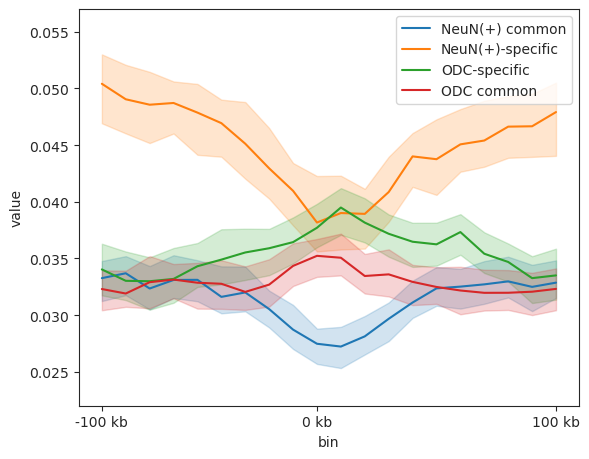

In [143]:
path = "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/bigwig/OLIG.merged.bigWig"
mark = path.split("/")[-3]
boundaries_files= [prep_dict_plus['plusFile_commonBorder'], prep_dict_plus['plusFile_neuronalBorder'], prep_dict_odc['odcFile_odcBorder'], prep_dict_odc['odcFile_commonBorder']]
names = ["NeuN(+) common", "NeuN(+)-specific", "ODC-specific", "ODC common"]
s, order = plot_lineplot_all(path, boundaries_files, names, errorbar='ci', method='median', save_path = f"/tank/projects/diana_hic/figs_hic_paper/figs_hic_paper_review/tad_border_profile_{mark}.pdf")

/tmp/ipykernel_24646/3079536817.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=0)


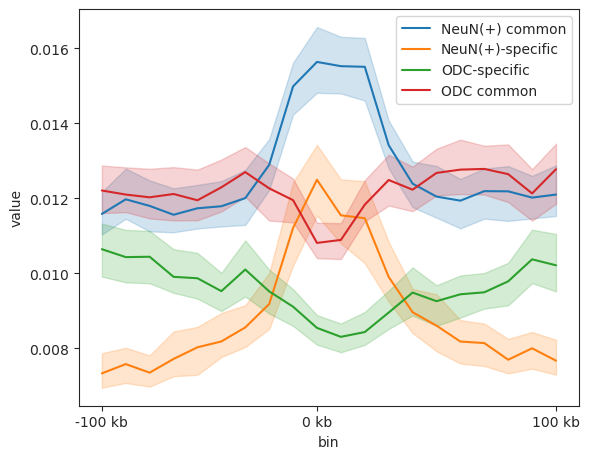

In [133]:
path = "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27ac/bigwig/H3K27ac_OLIG.merged.bigWig"
mark = path.split("/")[-3]
boundaries_files= [prep_dict_plus['plusFile_commonBorder'], prep_dict_plus['plusFile_neuronalBorder'], prep_dict_odc['odcFile_odcBorder'], prep_dict_odc['odcFile_commonBorder']]
names = ["NeuN(+) common", "NeuN(+)-specific", "ODC-specific", "ODC common"]
s, order = plot_lineplot_all(path, boundaries_files, names, errorbar='ci', method='median', save_path = f"/tank/projects/diana_hic/figs_hic_paper/figs_hic_paper_review/tad_border_profile_{mark}.pdf")